<a href="https://colab.research.google.com/github/dyjdlopez/intro_2_quantum/blob/main/cuda-q/12_hybrid_qnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12 Quantum Machine Learning - Hybrid Quantum Neural Networks
$_{\text{Made by: @dyjdlopez}}$


In this notebook we will look at how to integrate QNNs with classical models. This can help in taking advantage of QNNs for deep learning models during the NISQ era. This pieces of codes in this notebook is taken from NVIDA CUDA-Qs implementation of HQNNs from this [source](https://nvidia.github.io/cuda-quantum/latest/applications/python/hybrid_quantum_neural_networks.html). Additional discussions and section are just made for discussion purposes. NVIDIA reserves all rights for the program parts of this work.

In [ ]:
# Install the relevant packages.

!pip install cudaq==0.9.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 5.6 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.9.1-py3-none-any.whl size=6855 sha256=80eec263215824e50ea8f863dc9dedb727f7f97b89abede78da0db6118310bf5
  Stored in directory: /root/.cache/pip/wheels/b0/ee/32/0ac9053509c0ba31e4bac6122454996a9a4e4d6523b1918d04
Successfully built cudaq


In [ ]:
# Import the relevant libraries

import cudaq
from cudaq import spin

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

torch.manual_seed(22)
cudaq.set_random_seed(44)

# 1. Choosing Hardware
In running cudaq `kernels` you can choose specific hardware for simulation. For this notebook, we are limited with CPU and GPU runtimes only.

In [ ]:
# Set CUDAQ and PyTorch to run on either CPU or GPU.

# device = torch.device('cpu')
# cudaq.set_target("qpp-cpu")

cudaq.set_target("nvidia")
device = torch.device("cuda:0")

# 2. Classical Data Preparation
Just like with any deep learning preparation, we need to prepare our datasets from any source for consumption. In this notebook, we will be working with the MNIST dataset and PyTorch as our classical deep learning development platform.

In [ ]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used

    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets

    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307), (0.3081))])

    dataset = datasets.MNIST("./data",
                             train=True,
                             download=True,
                             transform=transform)

    # Filter out the required labels.
    idx = (dataset.targets == target_digits[0]) | (dataset.targets
                                                   == target_digits[1])
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]

    # Select a subset based on number of datapoints specified by sample_count.
    subset_indices = torch.randperm(dataset.data.size(0))[:sample_count]

    x = dataset.data[subset_indices].float().unsqueeze(1).to(device)

    y = dataset.targets[subset_indices].to(device).float().to(device)

    # Relabel the targets as a 0 or a 1.
    y = torch.where(y == min(target_digits), 0.0, 1.0)

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size /
                                                        100,
                                                        shuffle=True,
                                                        random_state=42)

    return x_train, x_test, y_train, y_test

In [ ]:
# Classical parameters.

sample_count = 1000  # Total number of images to use.
target_digits = [5, 6]  # Hand written digits to classify.
test_size = 30  # Percentage of dataset to be used for testing.
classification_threshold = 0.5  # Classification boundary used to measure accuracy.
epochs = 3  # Number of epochs to train for.

# Quantum parmeters.

qubit_count = 1
hamiltonian = spin.z(0)  # Measurement operator.
shift = torch.tensor(torch.pi / 2)  # Magnitude of parameter shift.

In [ ]:
x_train, x_test, y_train, y_test = prepare_data(target_digits, sample_count,
                                                test_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]


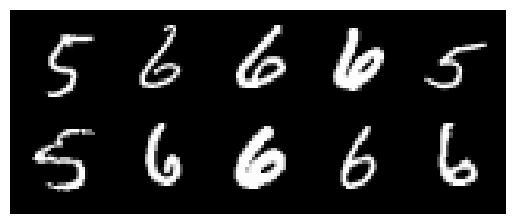

In [ ]:
# Plot some images from the training set to visualise.
if device != 'cpu':
    sample_to_plot = x_train[:10].to(torch.device('cpu'))
else:
    sample_to_plot = x_train[:10]

grid_img = torchvision.utils.make_grid(sample_to_plot,
                                       nrow=5,
                                       padding=3,
                                       normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

# 3. Preparing the QNNs
We will be preparing a QNN similar in tutorial 10.1 on QNNs. For a review, QNNs have four parts: (a) quantum encoder, (b) parameterized unitaries, (c) quantum correlation layers, and (d) measurement layers. Since we will be integrating the QNNs in the classical deep learning pipeline we need to create a customized function in PyTorch so that we can use it as a layer. To do that we need to create a functional layer that does the quantum operations we need. Our functional layer class would need to inherit from PyTorch's `autograd.Function` class. We need to prepare the forward propagation and backward propagation routine.

The forward propagation just comprise of the QNN architecture compilation and the expectation value computation while the backward propagation includes the gradient computation using parameter-shift rule.

In [ ]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            ## However NVIDIA did not include a quantum encoder, why so?
            ## You can also implement one on your own. Try to implement a quantum encoder here:
            ### CODE YOUR QUANTUM ENCODER HERE###

            ### END OF CUSTOM CODE ##

            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]

        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count,
                                theta_vals)

        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)

        ctx.save_for_backward(thetas, exp_vals)

        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference"""

        thetas, _ = ctx.saved_tensors

        gradients = torch.zeros(thetas.shape, device=device)

        for i in range(thetas.shape[1]):

            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

        gradients = torch.mul(grad_output, gradients)

        return gradients, None, None

Finally we encapsulate our function as an `nn.Module` to use it as a deep learning layer in our model schema.

In [ ]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit into a quantum layer adhering PyTorch convention"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):

        result = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return result

# 4. Creating the Hybrid QNN Pipeline
Once we have prepared the QNN layer we can now integrate the layer with the other classical models. This architecture implements the QNN as the output layer.

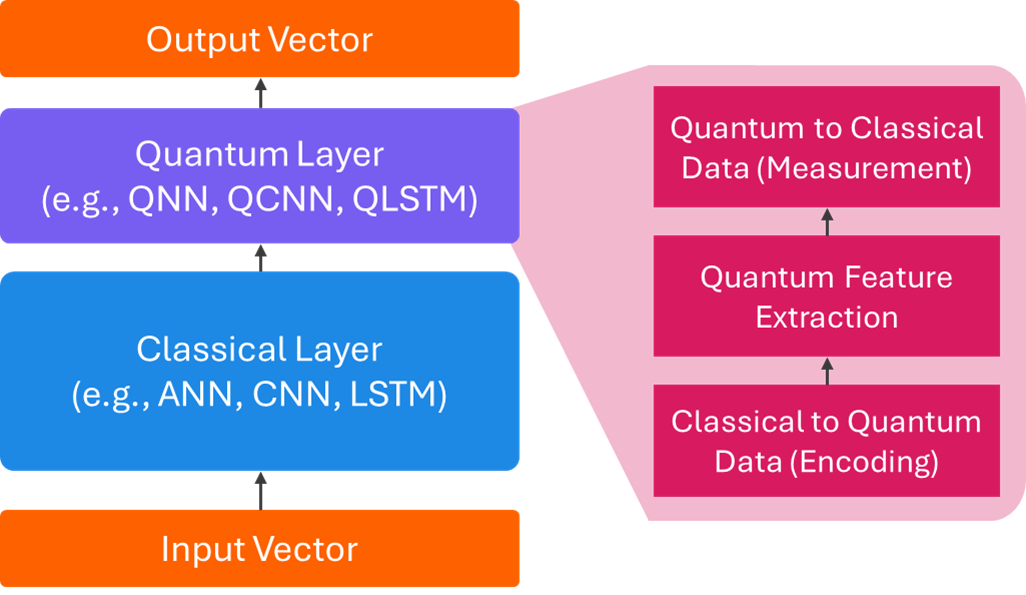

In [ ]:
class Hybrid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hybrid_QNN, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift)

    def forward(self, x):

        x = x.view(-1, 28 * 28)  # Turns images into vectors.

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)

In [ ]:
def accuracy_score(y, y_hat):
    return sum((y == (y_hat >= classification_threshold))) / len(y)

In [ ]:
hybrid_model = Hybrid_QNN().to(device)

optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in tqdm(range(epochs)):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
TypeError: can't convert cuda:0 device type

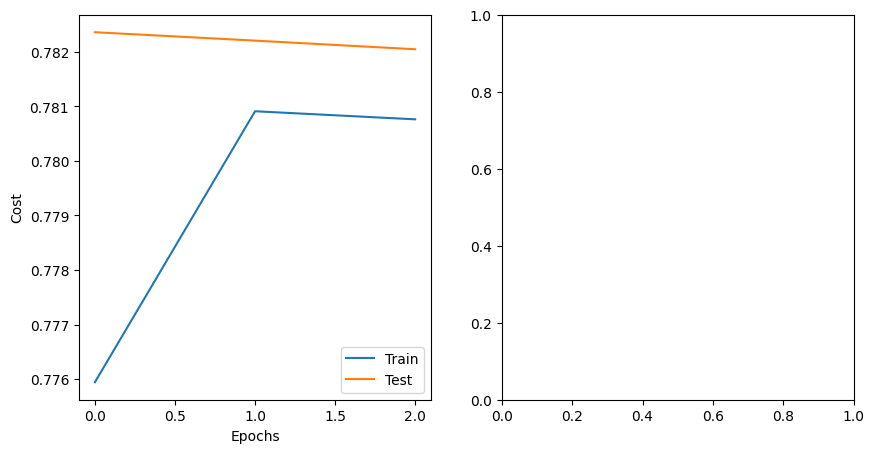

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()